# Homework 3 - Question 1 - Luke Arend

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.fft import fft, fftshift
from hw3.unknownSystemsAll import unknown_systems as us
neuron1 = us.unknown_system_1
neuron2 = us.unknown_system_2
neuron3 = us.unknown_system_3

You are trying to experimentally characterize three auditory
neurons, in terms of their responses to sounds. For purposes of this problem, the responses of
these neurons are embodied in compiled matlab functions `unknownSystemX.p` with $X = 1, 2,
3$. If you are using Python, import the unknown systems module from the obfuscated Python
file. Each takes an input column vector of length $N = 64$ whose elements represent sound
pressure over time. In Python the response of each is a column vector (of the same length)
representing the mean spike count over time. For each neuron,

# a)

“Kick the tires” by measuring the response to an impulse in the first position of an input vector. Check that the system is consistent with shift-invariance by comparing this to the response to an impulse at positions $n = 2, 4, 8$. Check that the system is consistent with linearity by asserting that the response to any combination of two impulses is equal to the sum of their individual responses. Also examine respones to impulses at different n to determine how the system handles inputs near the boundary (i.e., whether the system does circular boundary-handling). Describe your findings.

In [2]:
def unit_impulse(idx=0):
    """ Produce a length-64 zero vector with a 1 at position `idx`. """
    signal = np.zeros(64)
    signal[idx] = 1
    return signal

In [3]:
def plot_impulse_response(system, positions=(0, 1, 3, 7)):
    """ Plot the system's response to up to four unit impulses. """
    fig, axs = plt.subplots(2, 2)
    for i, pos in enumerate(positions):
        plt.sca(axs.flat[i])
        impulse = unit_impulse(idx=pos)
        response = pd.Series(system(impulse))
        plt.title(f'Impulse(t={pos})')
        sns.lineplot(impulse, label='Input')
        sns.lineplot(response, label='Response')
        plt.legend()
        if i % 2 == 0:
            plt.ylabel('Mean spike count')
        if i >= 2:
            plt.xlabel('Time step')
    plt.tight_layout()

In [4]:
def obeys_shift_invariance(system):
    """ Return True if the system's response to a unit impulse at time t
    equals its response to the unit impulse at time 0 shifted by t. """
    response_0 = system(unit_impulse(0))
    for i in range(1, 64):
        response = system(unit_impulse(idx=i))
        shifted = np.concatenate([response[i:], response[:i]])
        if not np.allclose(shifted, response_0):
            return False
    return True

In [5]:
response = neuron1(unit_impulse(idx=3))

In [6]:
def obeys_linear_superposition(system):
    """ Return True if the system's response to a sum of any two
    impulses equals the sum of its responses to each impulse. """
    for i in range(64):
        for j in range(64):
            signal1 = unit_impulse(i)
            signal2 = unit_impulse(j)
            response1 = system(signal1)
            response2 = system(signal2)
            response3 = system(signal1 + signal2)
            if not np.allclose(response1 + response2, response3):
                return False
    return True

### Neuron 1

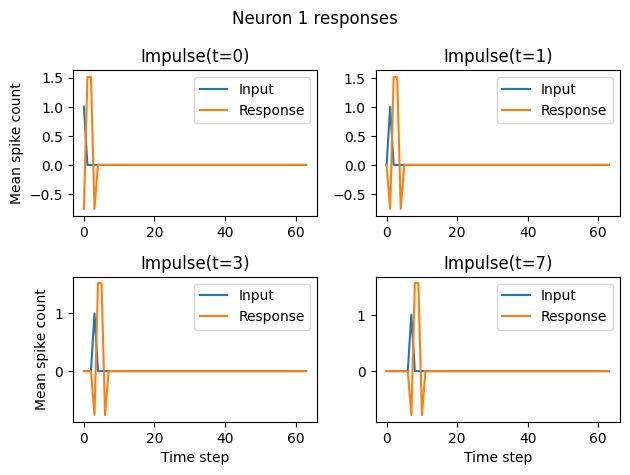

In [7]:
plot_impulse_response(neuron1, positions=[0, 1, 3, 7])
plt.suptitle(f'Neuron 1 responses')
plt.tight_layout()

Neuron 1 might seem shift-invariant if you check its responses to step functions in the first few time steps. But compare unit functions at `t=0` and `t=32`:

In [8]:
response1 = neuron1(unit_impulse(0))
response2 = neuron1(unit_impulse(32))
np.max(response1), np.max(response2)

(1.5099980968844182, 2.4000000000000004)

In [9]:
obeys_shift_invariance(neuron1)

False

The responses to an impulse function changes amplitude as we shift the input in time. So Neuron 1 **is not shift-invariant**.

In [10]:
obeys_linear_superposition(neuron1)

True

Neuron 1 **is linear** in that its response obeys linear superposition.

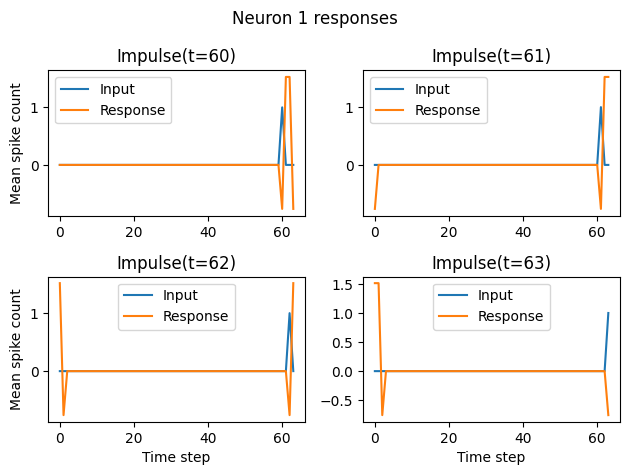

In [11]:
plot_impulse_response(neuron1, positions=[60, 61, 62, 63])
plt.suptitle(f'Neuron 1 responses')
plt.tight_layout()

The response to impulses at timesteps `t = [60, 61, 62, 63]` shows that Neuron 1 **does circular boundary-handling** (it views the end of its input range as wrapping around to connect with the beginning).

### Neuron 2

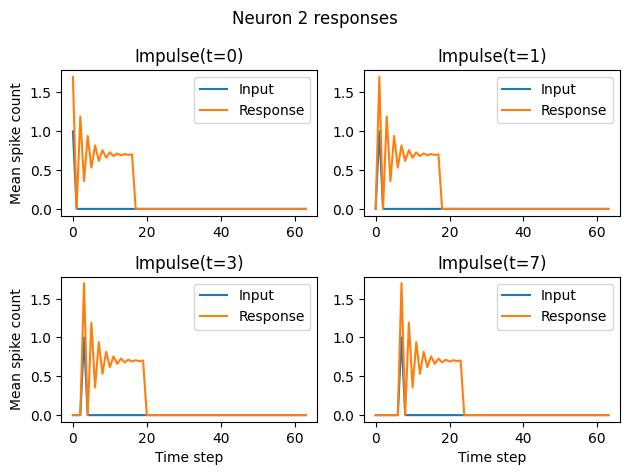

In [12]:
plot_impulse_response(neuron2, positions=[0, 1, 3, 7])
plt.suptitle(f'Neuron 2 responses')
plt.tight_layout()

In [13]:
obeys_shift_invariance(neuron2)

True

Neuron 2 **may be shift-invariant**, since its response to an impulse function only shifts (and does not change otherwise) as we shift the input in time.

In [14]:
obeys_linear_superposition(neuron2)

True

Neuron 2 **may be linear**, since its response to impulses obeys linear superposition.

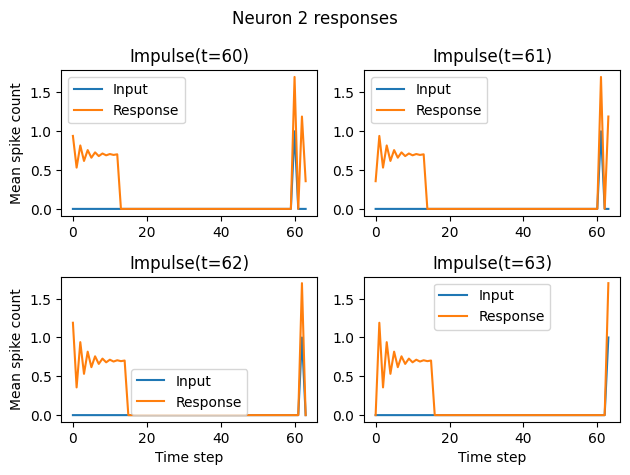

In [15]:
plot_impulse_response(neuron2, positions=[60, 61, 62, 63])
plt.suptitle(f'Neuron 2 responses')
plt.tight_layout()

The response to impulses at timesteps `t = [60, 61, 62, 63]` shows that Neuron 2 **does circular boundary-handling**.

### Neuron 3

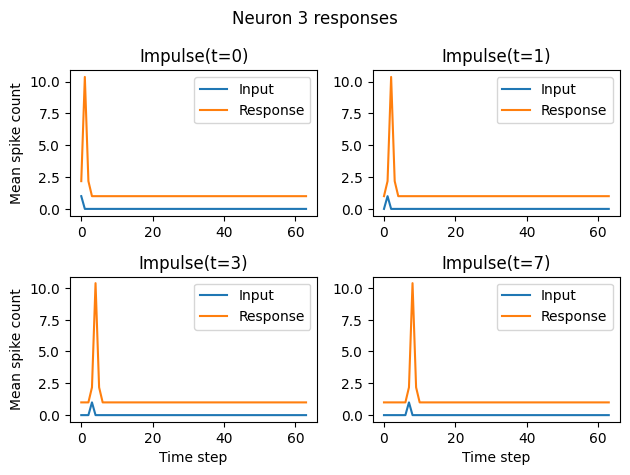

In [16]:
plot_impulse_response(neuron3, positions=[0, 1, 3, 7])
plt.suptitle(f'Neuron 3 responses')
plt.tight_layout()

In [17]:
obeys_shift_invariance(neuron3)

True

Neuron 3 **may be shift-invariant** in that its response to an impulse function merely shifts as we shift the input in time.

In [18]:
obeys_linear_superposition(neuron3)

False

Neuron 3 **is not linear** as its response does not obey linear superposition.

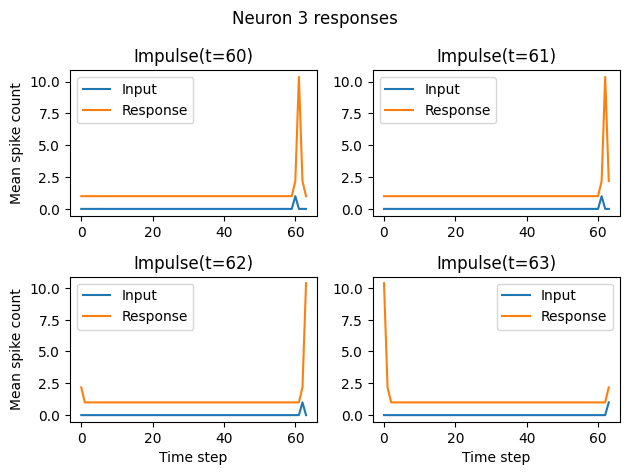

In [19]:
plot_impulse_response(neuron3, positions=[60, 61, 62, 63])
plt.suptitle(f'Neuron 3 responses')
plt.tight_layout()

The response to impulses at timesteps `t = [60, 61, 62, 63]` shows that Neuron 3 **does circular boundary-handling**.

# b)

If the previous tests succeeded, examine the response of the system to sinusoids with frequencies ${2π/N, 4π/N, 8π/N, 16π/N}$, and random phases, and check whether the outputs are sinusoids of the same frequency (i.e., verify that the output vector lies completely in the subspace containing all the sinusoids of that frequency). [Note: make all elements of the the input stimuli positive, by adding one to each sinusoid. The responses will then also be positive (mean spike counts).]

In [20]:
def make_sinusoid(ncycles):
    x = np.arange(64) / 64
    return np.sin(ncycles * 2 * np.pi * x + np.random.rand())

def plot_responses(inputs, responses, fourier=False):
    """ Plot up to four input-response pairs. """
    fig, axs = plt.subplots(2, 2)
    for i, (signal, response) in enumerate(zip(inputs, responses)):
        plt.sca(axs.flat[i])
        x = np.arange(-32, 32) if fourier else np.arange(64)
        sns.lineplot(x=x, y=signal, label='Input')
        sns.lineplot(x=x, y=response, label='Response')
        plt.legend()
        if i % 2 == 0:
            plt.ylabel('Amplitude' if fourier else 'Mean spike count')
        if i >= 2:
            plt.xlabel('Frequency' if fourier else 'Time step')
    plt.tight_layout()

ncycles = [1, 2, 4, 8]
sinusoids = [make_sinusoid(n) + 1.0 for n in ncycles]

The previous tests indicated that **Neuron 2** was linear and shift-invariant.

### Neuron 2

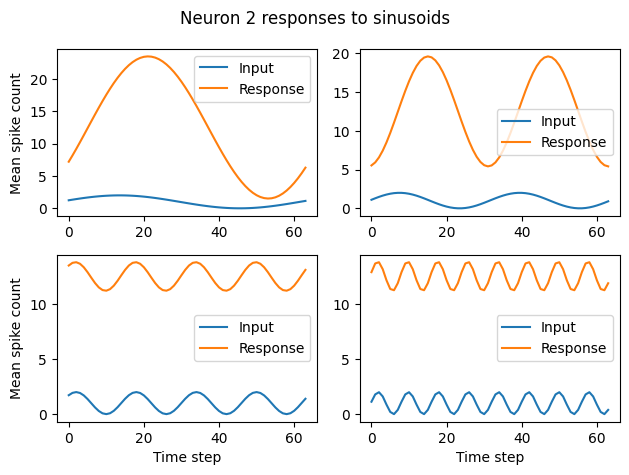

In [21]:
responses = [neuron2(s) for s in sinusoids]
plot_responses(sinusoids, responses)
plt.suptitle(f'Neuron 2 responses to sinusoids')
plt.tight_layout()

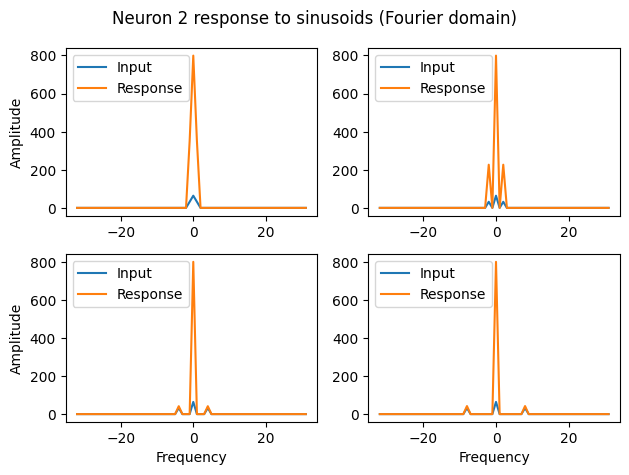

In [22]:
inputs_fft = [fftshift(fft(s)) for s in sinusoids]
responses_fft = [fftshift(fft(neuron2(s))) for s in sinusoids]
plot_responses(np.abs(inputs_fft), np.abs(responses_fft), fourier=True)
plt.suptitle(f'Neuron 2 response to sinusoids (Fourier domain)')
plt.tight_layout()

In the Fourier domain, we see that the response to each sinusoid contains only the frequency present in the input signal (as well as a DC bias at frequency 0 due to adding a constant to the input sinusoids). This means that each output vector lies completely in the subspace spanned by sinusoids with the input frequency.

# c)

If the previous tests succeeded, verify that the change in amplitude and phase from input to output is predicted by the amplitude (`abs`) and phase (`angle`) of the corresponding terms of the Fourier transform of the impulse response. If not, explain which property (linearity, or shift-invariance, or both) seems to be violated by the system. If so, does the combination of all of your tests guarantee that the system is linear and shift-invariant? What set of tests would provide such a guarantee?

### Neuron 1

Neuron 1 may be linear but is not shift-invariant. It obeys linear superposition for impulse functions but does not obey shift-invariance since the amplitude of a response depends on the impulse's position in time.

### Neuron 2

Neuron 2 may be shift-invariant and may be linear.

First let's inspect the Fourier spectra (both amplitude and phase) for an impulse signal at `t=0` and its response.

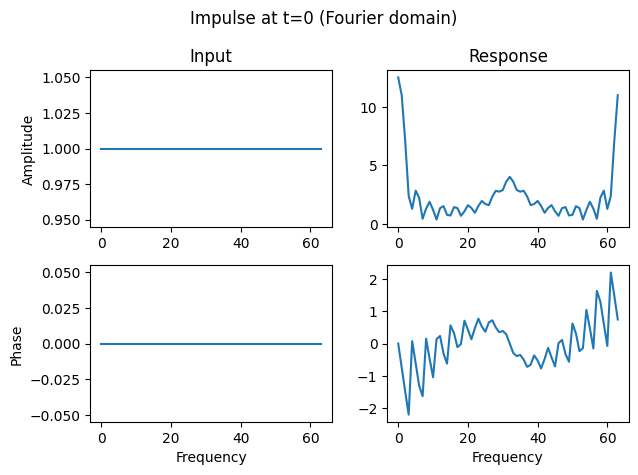

In [23]:
signal = unit_impulse(0)
response = neuron2(signal)
signal_fft = fft(signal)
response_fft = fft(response)

fig, axs = plt.subplots(2, 2)
plt.suptitle('Impulse at t=0 (Fourier domain)')
plt.sca(axs[0][0])
plt.title('Input')
sns.lineplot(np.abs(signal_fft))
plt.ylabel('Amplitude')
plt.sca(axs[0][1])
plt.title('Response')
sns.lineplot(np.abs(response_fft))
plt.sca(axs[1][0])
sns.lineplot(np.angle(signal_fft))
plt.ylabel('Phase')
plt.xlabel('Frequency')
plt.sca(axs[1][1])
sns.lineplot(np.angle(response_fft))
plt.xlabel('Frequency')
plt.tight_layout()

Looking at indexes 1, 2, 4 and 8 in `signal_fft` and `response_fft` tells us the amplitude/phase of real components with 1, 2, 4 and 8 cycles in the input and response, respectively. Amplitude is given by the `abs` and phase by the `angle` of the complex number. So for the n-cycle frequency, we can get the amplitude change `np.abs(response_fft[n]) / np.abs(signal_fft[n])` and the phase shift as `np.angle(response_fft[n]) / np.angle(signal_fft[n])`.

We can compare these to the amplitude and phase differences measured from experiments on the system.

In [24]:
def predict_amplitude_change(system, signal, ncycles):
    response = system(signal)
    signal_amp = np.abs(fft(signal))[ncycles]
    response_amp = np.abs(fft(response))[ncycles]
    return response_amp / signal_amp

def predict_phase_shift(system, signal, ncycles):
    response = system(signal)
    signal_phase = np.angle(fft(signal))[ncycles]
    response_phase = np.angle(fft(response))[ncycles]
    return signal_phase - response_phase

def measure_amplitude_change(signal, response):
    return np.max(response) / np.max(signal)

def measure_phase_shift(signal, response):
    signal -= np.mean(signal)
    response -= np.mean(response)
    signal /= np.max(signal)
    response /= np.max(response)
    val = 2 * np.mean(signal * response)
    if val > 1:
        val = val - 2
        return np.arccos(val)
    return np.arccos(val)

In [25]:
df = pd.DataFrame()
responses = [neuron2(s) for s in sinusoids]
for n, signal, response in zip(ncycles, sinusoids, responses):
    row = f'{n}-cycle sinusoid'
    df.loc[row, 'Amplitude scaling (predicted)'] = predict_amplitude_change(neuron2, signal, n)
    df.loc[row, 'Amplitude scaling (measured)'] = measure_amplitude_change(signal, response)
    df.loc[row, 'Phase shift (predicted)'] = predict_phase_shift(neuron2, signal, n) % np.pi
    df.loc[row, 'Phase shift (measured)'] = measure_phase_shift(signal, response) % np.pi
df

,Amplitude scaling (predicted),Amplitude scaling (measured),Phase shift (predicted),Phase shift (measured)
1-cycle sinusoid,10.979091,11.740405,0.746050,0.744782
2-cycle sinusoid,7.083784,9.807816,1.487737,1.487369
4-cycle sinusoid,1.296524,6.890914,3.067542,3.096255
8-cycle sinusoid,1.319229,6.907909,2.990225,2.864089


We find very good agreement between predictions and experiment.

Our tests show that Neuron 2:
1. is invariant to shifts (for impulse functions),
2. obeys linear superposition (for impulse functions), and
3. respects the amplitude and phase scaling predicted by the Fourier transform (for impulse functions).

These tests **do not guarantee** that the system is linear nor shift-invariant in general. I can imagine the "black-box" system containing a rule that produces a nonlinear and/or non-shift-invariant response only for very particular input vectors which simply aren't tested here. The only way to conclusively demonstrate that the system is linear and shift-invariant is to test it on all possible inputs.

### Neuron 3

Neuron 3 may be shift-invariant but is not linear. It obeys shift invariance for all impulse functions individually. However, we cannot say it is shift-invariant for general inputs (i.e. sums of impulse functions). Neuron 3 does not obey linear superposition for sums of impulse, so we have no guarantee that it will handle the individual components of the input in a linear way.